SAYANTAN CHAKRABORTY, MSG2022001, MTECH IT SYSTEMS

QUESTION - 1

In [19]:
# importing libraries and reading the image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

img = plt.imread('rgb_image.jpg')

In [20]:
# creating h s v values

h = img[:,:,0]
s = img[:,:,1]
v = img[:,:,2]
output = [img, h, s, v]
title = ['Image','Hue','Saturation','Value']

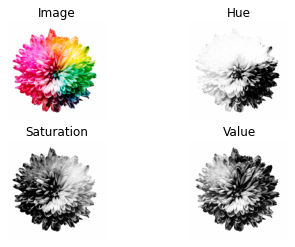

In [21]:
for i in range(4):
  plt.subplot(2, 2, i + 1)
  plt.axis('off')
  plt.title(title[i])

  if i == 0:
    plt.imshow(output[i])
  else:
    plt.imshow(output[i], cmap = 'gray')

QUESTION - 2

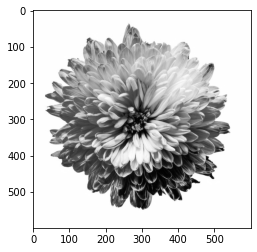

In [15]:
# importing libraries and reading the image

import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

img = plt.imread('rgb_image.jpg');
img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
plt.imshow(img, cmap = 'gray')

In [ ]:
# creating histogram

img_1D = img.ravel()
n_bins = 128;
plt.hist(img_1D, bins = n_bins)
counts, edges = np.histogram(img, bins = n_bins)
bin_centers = edges[:-1] + np.diff(edges) / 2

In [13]:
# function for threshold

def ssd(counts, centers):
  n = np.sum(counts)
  mu = np.sum(centers * counts) / n
  return np.sum(counts * ((centers - mu) ** 2))

In [14]:
# applying OTSU's algorithm

total_ssds = []

for bin_no in range(1, n_bins):
  left_ssd = ssd(counts[:bin_no], bin_centers[:bin_no])
  right_ssd = ssd(counts[bin_no:], bin_centers[bin_no:])
  total_ssds.append(left_ssd + right_ssd)

z = np.argmin(total_ssds)
t = bin_centers[z]

print('Otsu bin(z) : ', z)
print()
print('Otsu threshold (c[z]) : ', bin_centers[z])

Otsu bin(z) :  82

Otsu threshold (c[z]) :  164.33903320312498


In [16]:
threshold_otsu(img, n_bins)

164.33903320312498

In [17]:
np.allclose(threshold_otsu(img, n_bins), t)

True

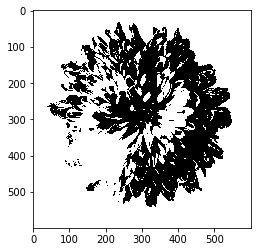

In [18]:
binarized = img > t
plt.imshow(binarized.T, cmap = 'gray', interpolation = 'nearest')

QUESTION NO. - 3

In [ ]:
import cv2
import numpy as np
from copy import deepcopy as cp


class Node:
    def __init__(self, f, p, isLeaf=0):
        self.freq = f          # For storing intensity
        self.prob = p          # For storing Probability
        self.word = ""         # For coded word ex : '100101'
        # Pointers for children, C[0] for left child, c[1] for right child
        self.c = [None, None]
        self.isLeaf = isLeaf   # Flag for Leaf-Nodes


class Image:
    def __init__(self):
        self.path_in = ""               # Input file Location
        self.path_out = ""              # Output file Location
        self.im = np.zeros(1)           # Input Image
        self.out = np.zeros(1)          # Output Image
        self.image_data = np.zeros(1)   # List of Intensities and dimensions
        self.r = 0                      # Rows
        self.c = 0                      # Coloums
        self.d = 0                      # Depth / channels

        # histogram, ie frequency count of each data value
        self.hist = np.zeros(1)
        self.freqs = np.zeros(1)        # For Non-zero frequency

        # Dictionary with key as freqs and values as Probailities
        self.prob_dict = {}
        self.allNodes = []              # Container for  All created Nodes
        self.leafNodes = {}             # Container for Leaf Nodes
        self.root = Node(-1, -1)        # Root Node with Probability = 1

        # Encoded String of Image,form: "01001010101011......", interpretation :  [r,c,d,[..pxls]]
        self.encodedString = ""

        # Decoded List of integers when read from .bin file, form : [456,342,3,34,2,120,44, ...... ], interpretation : [r,c,d,[..pxls]]
        self.decodeList = []

        # Binary from file in for of integers ie [0,1,0,0,1,0,1,0,1,0,1,0,1,1,......]
        self.binaryFromFile = []

In [ ]:
def readImage(self, path):
        self.path_in = path
        try:
            self.im = cv2.imread(path)
        except:
            print("Error in reading image")

def initialise(self):
  self.r, self.c, self.d = self.im.shape

  # Pushing r,c,d to encode into image_data list

  temp_list = self.im.flatten()
  temp_list = np.append(temp_list, self.r)
  temp_list = np.append(temp_list, self.c)
  temp_list = np.append(temp_list, self.d)

  self.image_data = temp_list

  # Creating historgram from image_data to create frequencies.

  self.hist = np.bincount(
            self.image_data, minlength=max(256, self.r, self.c, self.d))
  total = np.sum(self.hist)

  # Extracting the non-zero frequencies

  self.freqs = [i for i, e in enumerate(self.hist) if e != 0]
  self.freqs = np.array(self.freqs)

  # Creating a dict of probabilities , with keys are intensities and value as propabilities

  for i, e in enumerate(self.freqs):
    self.prob_dict[e] = self.hist[e]/total

In [ ]:
# Creating Nodes for intensities
    def buildNodes(self):
        for key in self.prob_dict:
            leaf = Node(key, self.prob_dict[key], 1)
            self.allNodes.append(leaf)

# comparator function for sorting
    def prob_key(self, e):
        return e.prob

# Creating UPTREE
    def upTree(self):

        import heapq
        self.buildNodes()        # Creating Nodes

        # Sorting all Nodes in workspace to create uptree
        workspace = sorted(cp(self.allNodes), key=self.prob_key)
        while(1):
            c1 = workspace[0]
            c2 = workspace[1]
            workspace.pop(0)
            workspace.pop(0)

            # Creating A new node from  two smallest propability intensities
            new_node = Node(-1, c1.prob+c2.prob)
            new_node.c[0] = c1
            new_node.c[1] = c2

            workspace = list(heapq.merge(
                workspace, [new_node], key=self.prob_key))   # Pushing the created Node into Workspace
            # Break if probability of prepared node is 1, indicating preparing upTree is completed
            if(new_node.prob == 1.0):
                self.root = new_node        # And storing it as root Node
                return

# Creating Down Tree ie assigning words to Leaf Nodes from Root
    def downTree(self, root, word):
        root.word = word
        if(root.isLeaf):
            self.leafNodes[root.freq] = root.word
        if(root.c[0] != None):
            self.downTree(root.c[0], word+'0')
        if(root.c[1] != None):
            self.downTree(root.c[1], word+'1')

    def huffmanAlgo(self):
        self.upTree()                   # Creating UpTree
        self.downTree(self.root, "")    # Creating DownTree

        dicti = {}                          # Storing the prob_dict in new variable dicti
        # So that we need not access ("self.") every time that costs time, we just use dicti in place of self.leafNodes
        for key in self.leafNodes:
            dicti[key] = self.leafNodes[key]

        # Storing the self.encodedString in new variable encodedString
        # So that we need not accecess "self." every time,which cost more time
        encodedString = ""
        encodedString += dicti[self.r]
        encodedString += dicti[self.c]
        encodedString += dicti[self.d]

        # Note we are first encoding dimensions, and later encoding each pxl in 3rd dimension order , later while decoding we decode in the same way

        for i in range(self.r):
            for j in range(self.c):
                for ch in range(self.d):
                    encodedString += dicti[self.im[i][j][ch]]

        self.encodedString = encodedString

In [ ]:
def sendBinaryData(self, path):
        #  Our self.encodedString is just list of strigs with characters char('0') & char('1')
        # but we should not directly write char('0') and char('1') , because each of them take 1byte = 8bits, so we are converting the char('0') and char('1') to binary(0) & binary(1)
        # To do the above work we are using bitstring from BitArray library
        from bitstring import BitArray
        file = open(path, 'wb')
        obj = BitArray(bin=self.encodedString)
        obj.tofile(file)
        file.close()

def decode(self, path):
        # Now we have a file , we will try to read its contents
        # For reading binary from file we are using bitarray library (this is different one from above used BitArray)

        import bitarray
        self.binaryFromFile = bitarray.bitarray()
        with open(path, 'rb') as f:
            self.binaryFromFile.fromfile(f)

        # Data type of self.binaryFromFile is list of int(0)'s and int(1)'s

        decodeList = []
        root = self.root
        temp_root = cp(self.root)

        temp_r = 0
        temp_c = 0
        temp_d = 0

        # Like we encoded r,c,d, we will first retrieve/decode them

        for i, c_int in enumerate(self.binaryFromFile):
            if(temp_r != 0 and temp_c != 0 and temp_d != 0 and len(decodeList) == (temp_r*temp_c*temp_d + 3)):
                break
            if(temp_r == 0 and len(decodeList) >= 1):
                temp_r = decodeList[0]

            if(temp_c == 0 and len(decodeList) >= 2):
                temp_c = decodeList[1]

            if(temp_d == 0 and len(decodeList) >= 3):
                temp_d = decodeList[2]

            # Start at root, if 0 go to left node, if 1 go to right node, if leafnode is found store the intensity in a list
            # and follow the same procedure untill you find (r*c*d + 3) values, ie 3 dimensions and r*c*d intensities

            temp_root = temp_root.c[c_int]
            if(temp_root.isLeaf):
                decodeList.append(temp_root.freq)
                temp_root = root
                continue

        self.decodeList = decodeList

    def decodeIm(self, path):
        self.decode(path)

        # Extracting dimensions values from deocded list, ie its first 3 three

        decodeList = self.decodeList
        out_r = decodeList[0]
        decodeList.pop(0)
        out_c = decodeList[0]
        decodeList.pop(0)
        out_d = decodeList[0]
        decodeList.pop(0)

        out = np.zeros((out_r, out_c, out_d))

        # Filling the out put image

        for i in range(len(decodeList)):
            id = i//out_d
            x = id//out_c
            y = id % out_c      # Basic parsing mathematics for finding index values
            z = i % out_d
            out[x][y][z] = decodeList[i]
        out = out.astype(dtype=int)
        self.out = out